# Imports

In [1]:
import os   # For path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Config GPU env

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9583882035408643230
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15315952294555332715
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Def NN

## Training options

In [3]:
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights_dxyz.hdf5", save_best_only=True, verbose =1)

## Create a 1D convnet based on the practice lesson for time series analysis

In [4]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    # Defining input shape of the first layer based on desired output type
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                    input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    return model

## Create input and output format from raw data

In [5]:
def make_timeseries_instances(timeseries, window_size, nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
    
    # We have 3 output signal: dx, dy and dz position    
    y = timeseries[window_size:,-3:]
        
    return X,y

## Train the network on timeseries

In [6]:
def evalute_timeseries(timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    
    # Define in and output size based on output type
    nb_inputs = nb_series - 11 # Only 10 inputs (previous x,y,z position is an input now)
    nb_outputs = 3
        
    # Initialize model
    model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    # Fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    # Load the best model for plotting
    bestmodel = load_model("CNN_weights_dxyz.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    # Plot the results based on output type
    # Plot predicted dx vs target dx
    plt.figure(0)
    plt.plot(preds[:,0],color = 'green', label = 'dx pred')
    plt.plot(targets[:,0],color = 'red', label = 'dx targ')
    
    # Plot predicted dz vs target dz
    plt.figure(1)
    plt.plot(preds[:,2],color = 'blue', label = 'dz pred')
    plt.plot(targets[:,2],color = 'yellow', label = 'dz targ')
    
    # Plot the predicted route vs original route on dx-dz plane
    plt.figure(2)
    plt.plot(preds[:,0],preds[:,2], label = 'dxz pred')
    plt.plot(targets[:,0],targets[:,2], label = 'dxz targ')
    
    return preds, targets

# Load data file

In [7]:
df = pd.read_csv('Bazs\\PreprocessedData_v3.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [8]:
df.head(2)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.02,0.001,1.0,0.0,0.0,0.0


# Set hyperparameters

In [9]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

# Train NN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             204       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 315
Trainable params: 315
Non-trainable params: 0
_________________________________________________________________
Train on 382


Epoch 00042: val_loss did not improve from 0.03622
Epoch 00042: early stopping


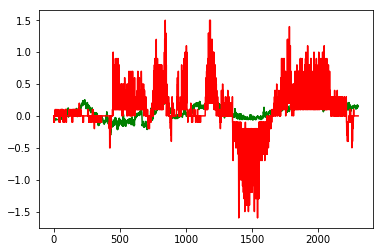

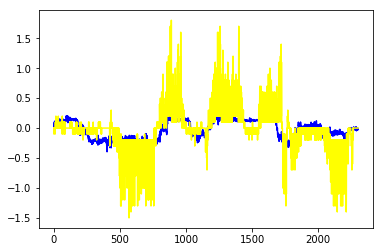

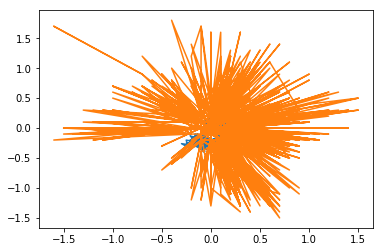

In [10]:
preds, targets = evalute_timeseries(df,window_size,filter_length,nb_filter, epochs, batch_size)

# Draw dxz position prediction with the model

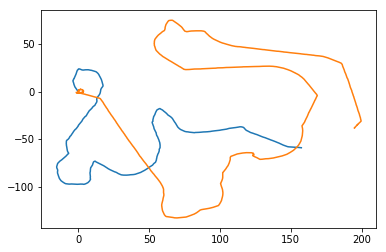

In [11]:
for i in range(preds.shape[0]):
    if i>0:
        preds[i,0] = preds[i-1,0] + preds[i,0]
        preds[i,1] = preds[i-1,1] + preds[i,1]
        preds[i,2] = preds[i-1,2] + preds[i,2]
        
        targets[i,0] = targets[i-1,0] + targets[i,0]
        targets[i,1] = targets[i-1,1] + targets[i,1]
        targets[i,2] = targets[i-1,2] + targets[i,2]


plt.plot(preds[:,0],preds[:,2], label = 'dxz pred')
plt.plot(targets[:,0], targets[:,2], label='xz targ')
plt.show()